In [1]:
import nasdaqdatalink
import os
import json
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_market_calendars as mcal
from datetime import datetime
import requests
from refresh_functions import *
pd.options.display.float_format = '{:.6f}'.format

#modelling packages ------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

from sklearn.feature_selection import RFECV
import shap

#store my API key
with open('C:/Users/meich/.nasdaq/data_link_apikey.json') as f:
    data=json.load(f)
    key=data['api_key']
quandl.ApiConfig.api_key = key

# Data Refresh & Load
-----
Next step: schedule this code block daily in the cloud (which means having cloud storage for the data also)

In [2]:
%%time

#PRICES 
sharadarSEP()
sep = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SEP.csv')

#TICKERS + CATEGORIES
tickers = sharadarTICKERS()

#DAILY FUNDAMENTALS
sharadarDAILY()
daily = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_DAILY.csv')
daily['marketcap_max'] = daily.groupby('ticker')['marketcap'].transform(max)
daily = daily[daily['marketcap_max']>=500]
daily['marketcap_total'] = daily.groupby('date')['marketcap'].transform(sum)

#SHORT INTEREST ACTIVITY (FINRA)
finraSHORTS()
si = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/FINRA_SI.csv')

#RETAIL TRADER ACTIVITY
nasdaqRTAT()
rtat = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv')

#INSIDER TRADING ACTIVITY 
sharadarSF2()
sf2 = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SF2.csv')

New Data---
2023-02-01 00:00:00
'sharadarSEP' 1.34 mins
'sharadarTICKERS' 0.50 mins
New Data---
2023-02-01 00:00:00
'sharadarDAILY' 1.76 mins
New Data---
2023-02-01
'finraSHORTS' 0.55 mins
New Data---
2023-02-01 00:00:00
'nasdaqRTAT' 1.80 mins
New Data---
2023-02-01 00:00:00
'sharadarSF2' 0.12 mins
Wall time: 6min 20s


## sf3 temp work

In [3]:
# # preferred stock, debt, calls, puts, warrants, funds, common shares
# # seems like most recent date is weird... not complete (45 days after 12-31 is last day to file..)

# #CAN JUST DOWNLOAD THIS WHEN NEW DATA BECOMES AVAILABLE.. 45 DAYS AFTER QUARTER END, ALL DATA IS IN.
# ###### VALENTINES DAY <3
# sf3 = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SF3A.csv')
# sf3 = sf3[['calendardate','ticker','shrholders','cllholders','putholders','shrvalue','cllvalue','putvalue','totalvalue',
#     'percentoftotal','shrunits','putunits','cllunits']]

# sf3 = sf3.set_index('calendardate').sort_index()
# sf3.index = pd.to_datetime(sf3.index)
# sf3 = sf3[sf3.index>'2016-12-31']

In [4]:
# #this is prime target for pct changes quarter to quarter...
# sf3['pc_value'] = sf3['putvalue']/sf3['cllvalue']
# sf3['pc_count_ratio'] = sf3['putholders']/sf3['cllholders']
# sf3['pc_units'] = sf3['putunits']/sf3['cllunits']
# sf3['net_option_value'] = sf3['cllvalue']-sf3['putvalue']

In [5]:
# sf3[sf3['ticker']=="MSFT"].iloc[:,1:].pct_change(2)

In [6]:
#sf3_daily = sf3.groupby('ticker').resample('D').ffill()

In [7]:
#first calculate rolling metrics, THEN
#need to expand values to daily dates, so can join


In [8]:
# px.line(sf3[sf3['ticker']=='GME'],
#         y='percentoftotal')

### Create foundational dataset (shar)

In [9]:
combined = daily.merge(tickers,left_on='ticker',right_on='ticker',how='left')
combined = combined.merge(sep,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(rtat,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(si,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(sf2,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined.sort_values(['ticker','date'],inplace=True)

### Feature Generation

In [10]:
#ADD PRICE METRICS - logdiff 
    # rdiff 	row-on-row % change	z[t] = (y[t] – y[t-1]) / y[t-1]
    # log returns ln(stock price t1/ stock price t0)
#LAG THE CLOSEADJ (TARGET) AND THE TOTAL MARKET VALUE (MARKET ADJUSTMENTS)
combined = lagged_features(combined)
combined = lagged_features(combined,ft='marketcap_total')

#add price adjusted (market) target variables (closemarket_pctY vs closeadj_pctY)
combined['closemarket_pct1'] = combined['closeadj_pct1'] - combined['marketcap_total_pct1']
combined['closemarket_pct5'] = combined['closeadj_pct5'] - combined['marketcap_total_pct5']
combined['closemarket_pct30'] = combined['closeadj_pct30'] - combined['marketcap_total_pct30']
combined['closemarket_pct90'] = combined['closeadj_pct90'] - combined['marketcap_total_pct90']
combined['closemarket_pct180'] = combined['closeadj_pct180'] - combined['marketcap_total_pct180']
combined['closemarket_pct360'] = combined['closeadj_pct360'] - combined['marketcap_total_pct360']

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (RELATIVE TO MARKET)
combined['closemarket_pos1'] = combined['closemarket_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos5'] = combined['closemarket_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos30'] = combined['closemarket_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos90'] = combined['closemarket_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos180'] = combined['closemarket_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos360'] = combined['closemarket_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (DISREGARDING MARKET)
combined['closeadj_pos1'] = combined['closeadj_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos5'] = combined['closeadj_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos30'] = combined['closeadj_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos90'] = combined['closeadj_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos180'] = combined['closeadj_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closeadj_pos360'] = combined['closeadj_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

'lagged_features' 0.66 mins
'lagged_features' 0.69 mins


In [11]:
#SI FEATURES
combined = short_features(combined)

'short_features' 0.91 mins


In [12]:
#ACTIVITY FEATURES
combined = rtat_features(combined)

'rtat_features' 0.92 mins


In [13]:
#features based on group by industry or sector and get pct diff from FOR fundamental cols
combined = fundamentals_features(combined)

'fundamentals_features' 0.12 mins


In [14]:
#label endcode categories
le = preprocessing.LabelEncoder()
combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

## EDA

In [15]:
#combined[combined['ticker']=='GME'].corr()['closeadj_pct1'].sort_values().tail(30)

In [20]:
px.line(combined[combined['ticker']=='GOOGL'],
       x='date',
       y='closemarket_pct30')

In [29]:
stock = combined[combined['ticker'] == 'GME'].copy()
stock = stock.sort_values(by='date')

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['closeadj'], name="price"),
    secondary_y=False,
)

# fig.add_trace(
#     go.Scatter(x=stock['date'], y=stock['ShortRatio_5_old'], name="var"),
#     secondary_y=True,
# )

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['pb_pct5'], name="var1"),
    secondary_y=True,
)

fig.show()

In [26]:
#Difference between TotalVolume & activity may give insights into non-retail activity
# px.scatter(combined[combined['ticker']=='MSFT'],
#           'pb_pct1','closeadj_pct1',trendline='ols')

In [27]:
#tesla is the outlier when it comes to activty vs future price
px.scatter(combined[combined['activity']>0.05],
       x='activity',
       y='closemarket_pct90',
           trendline='ols'
      )

# Regression

This is a lot more difficult than predicting direction... and driven somewhat by outliers.. may make sense to clip or quantile bucket

something is off -- model too good.. possibly market cap is biasing the model --

THIS is the biggest potential problem - my observations are related. (i.e. by ticker)

- possible leakers: raw volume, raw activity, fundamentals

test 1 ticker at a time, or see plot target for 1 ticker at a time, or run multiple models w/ 1 ticker sampled in each model

try group k fold


In [28]:
# #ADD PCT CHANGE FEATURES TO MANY VARIABLES -- each addition will multiply data by 4 though.. should keep if they improve model only

# pctchange_features(combined,['pb'])

In [71]:
%%time
#SET OUR DATA, FEATURES, TARGET
# activity >.001 -> .63 score
# entire dataset -> .31 score (1hr 40min run)
# close adj 30 score (instead of closemarket score)  -> .65, about the same, maybe better?
# cashdebt add -> .69
# industry features add -> .76


data = combined[combined['activity']>= 0.001 ].copy()
vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int','cashdebt',
       'cashdebt_industry','pe_industry','pb_industry','ps_industry','evebitda_industry']

target = 'closeadj_pct30'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)


##ADD CROSS VAL TESTING HERE TO ADD AND REMOVE VARIABLES
# tree_method='gpu_hist',predictor='gpu_predictor' parameters force GPU usage---> wayy faster, plus doesn't use 100% cpu
#     2 mins + vs 14 seconds
reg = XGBRegressor(n_estimators=1000,tree_method='gpu_hist',predictor='gpu_predictor')
np.mean(cross_val_score(reg,X_train,y_train))

Wall time: 28.3 s


0.7643843575478815

In [47]:
# # USE FWD SELECTION TO GET RELEVANT FEATURES... WILL RUN +1 TIMES FOR EACH CV SET--------------------------
# sfs = RFECV(reg,step=1,cv=4,verbose=1)
# sfs.fit(X_train,y_train)

# #I get p much same results as shap feature importance -- so can ignore this for now - drop low-end variables
# print(f"Optimal number of features: {sfs.n_features_}")
# pd.Series(sfs.cv_results_['mean_test_score']).plot()
# pd.DataFrame([sfs.ranking_,sfs.feature_names_in_]).T

In [72]:
%%time
reg.fit(X_train,y_train)
predictions = reg.predict(X_test)

Wall time: 5.74 s


In [73]:
# from sklearn.preprocessing import QuantileTransformer
# xgbtranstarget = TransformedTargetRegressor(
#      regressor=XGBRegressor(n_estimators=1000), 
#     transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
#  ).fit(X_train, y_train)

# predictions = xgbtranstarget.predict(X_test)

In [74]:
#performance checks
print('---- test set results ----')
print('MAE: ',mean_absolute_error(y_test, predictions))
print('MSE: ',mean_squared_error(y_test, predictions))
print('R2: ',r2_score(y_test, predictions))

X_test['preds'] = predictions
X_test['true'] = y_test

#bias checks
print('unique predictions vs true value length: ',X_test['preds'].nunique()/len(X_test))
print('real mean: ',X_test['true'].mean())
print('predicted mean: ',X_test['preds'].mean())

---- test set results ----
MAE:  5.236900055121206
MSE:  91.03343351335981
R2:  0.7672945494576088
unique predictions vs true value length:  0.9993375766826992
real mean:  1.130727797065251
predicted mean:  1.2282936573028564


In [75]:
#Inspect predictions vs True Values for pct change in price
px.scatter(X_test,
          'preds',
          'true',
           color='ps',
          trendline='ols')

In [186]:
# le = preprocessing.LabelEncoder()
# combined['sector_int'] = le.fit_transform(combined['sector'].astype(str))
# combined['industry_int'] = le.fit_transform(combined['industry'].astype(str))
# data = combined[combined['activity']>= 0.01 ].copy()

# #try transform target, since outliers -- has huge impact on performance

# vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
#         'activity_5','sentiment_5','ShortRatio_5','TotalVolume_5',
#         'activity','sentiment','ShortRatio','TotalVolume',
#         'evebitda','ps','pb','pe','marketcap','sector_int','industry_int']

# target = 'closemarket_pct30'

# X_train, X_test, y_train, y_test = model_setup(
#         data,
#      vars, 
#     target)

# visualizer = ResidualsPlot(XGBRegressor(n_estimators=1000))

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure

C:\Users\meich\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



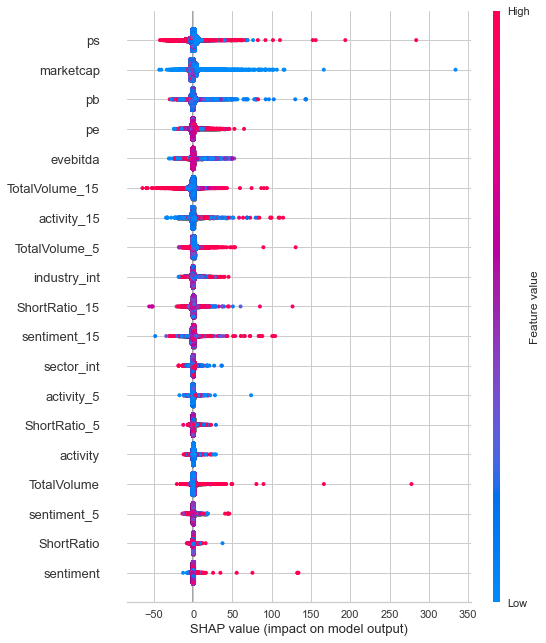

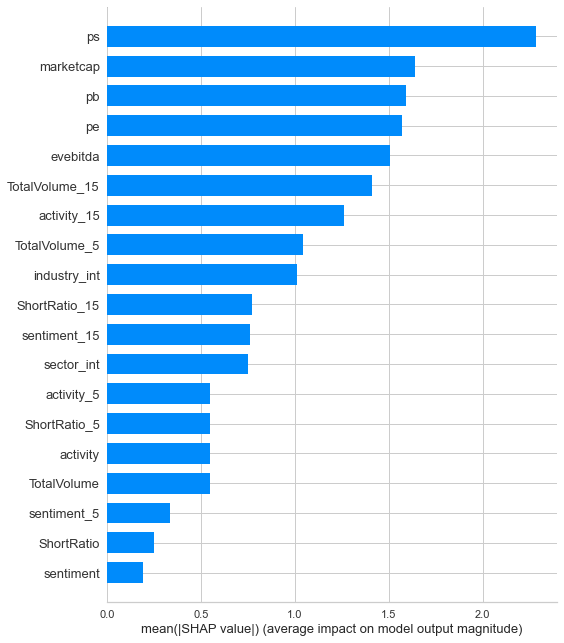

In [38]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)

#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Classifier

as i increase the rolling timespan, accuracy goes up for 180 prediction -- is this leakage? Model actually seems good (suspicious) - 86% acc, .94 rocauc

    - pos180 vs 30(act,sent,shortratio,totalvolume)
    - when activtiy > 0.01

i bet totalvolume is having some leakage -- not standardized (dropping it does remove about 9 pts of acc)

    - see below about signaling ticker (anyone can predict the ticker from this info, not the task)

does this hold up when I use entire dataset??

When i add evebitda, acc goes wayyy up - has to be leakage (YES - bc evebitda would signal which ticker it is -- need evebitda change maybe)

    - I think the other variables may be signaling the ticker as well

In [76]:
data = combined[combined['activity']>= 0.001 ].copy()
vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15',
        'evebitda','ps','pb','pe','marketcap','sector_int','industry_int','cashdebt',
       'cashdebt_industry','pe_industry','pb_industry','ps_industry','evebitda_industry']

target = 'closemarket_pos30'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

In [77]:
%%time
#fit and predict 
bst = XGBClassifier(n_estimators=1000,eval_metric='error',tree_method='gpu_hist',predictor='gpu_predictor',
                   use_label_encoder=False)
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)
probpredictions = bst.predict_proba(X_test)[:,1]

Wall time: 5.6 s


In [78]:
y_test.mean()

0.48820598485066674

In [79]:
accuracy_score(y_test,predictions)

0.8769044670372397

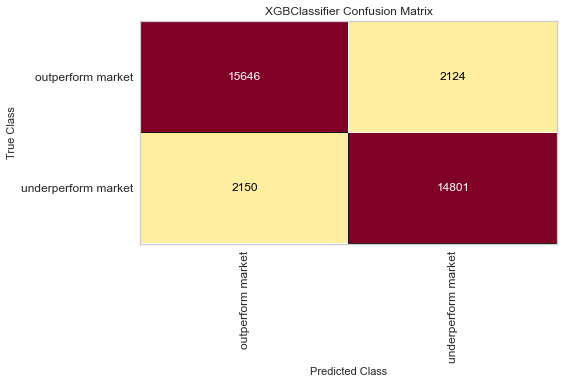

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [80]:
#show classification results in graphs
visualizer = ConfusionMatrix(bst,
                            classes=['outperform market','underperform market'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

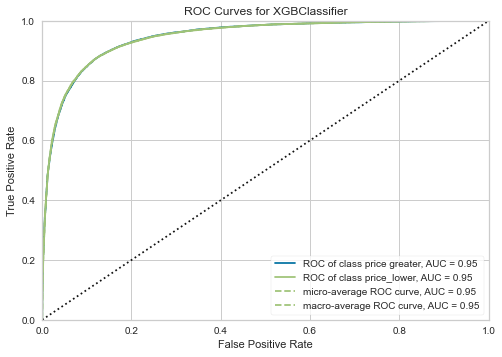

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [81]:
visualizer = ROCAUC(bst,
                   classes=['price greater','price_lower'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [82]:
X_test['preds'] = predictions
X_test['proba_preds'] = probpredictions
X_test['true'] = y_test

In [83]:
#shap values or some contribution goal
# what's a good way to look at proba preds vs true class (to see if my probabilities are legit)
X_test['ticker'] = combined['ticker']
X_test['date'] = combined['date']
X_test['market chng'] = combined['closemarket_pct180']
X_test['actual chng'] = combined['closeadj_pct180']
X_test['proba_bins'] =pd.cut(X_test['proba_preds'],10,right=False,labels=False)
X_test['correct'] = X_test['preds'] ==X_test['true']

In [84]:
# actual mean value vs each predicted probability bin - see a linear trend
px.bar(X_test.groupby('proba_bins').mean(),
       x=X_test.groupby('proba_bins').mean().index,
       color='correct',
       y='true')

In [56]:
X_test[X_test['ticker'] =='MSFT']['preds'].mean()

0.7912457912457912

In [57]:
X_test[X_test['ticker'] =='MSFT']['true'].mean()

0.7845117845117845

In [92]:
# predict on newest date
newdata = combined[(combined['date'] == '2023-02-01' ) & (combined['activity']>.001)][vars]
newpreds = bst.predict(newdata)
newproba = bst.predict_proba(newdata)[:,1]

newdata['preds'] = newpreds
newdata['proba_prebs'] = newproba
newdata['ticker'] = combined['ticker']
newdata['date'] = combined['date']
newdata['activity'] = combined['activity']

newdata.sort_values(['proba_prebs'])

activity_15  sentiment_15  ShortRatio_15   TotalVolume_15  \
5924766     0.157447     -0.800000       0.589674 125522175.266667   
5927124     0.003340      6.266667       0.428492  28390965.400000   
5926336     0.002633      3.133333       0.562248  23674081.266667   
5925363     0.002920      2.466667       0.442906  15606759.533333   
5925915     0.003140      0.066667       0.412365  22815276.800000   
...              ...           ...            ...              ...   
5926455     0.002553     -2.933333       0.380783   3554178.533333   
5924416     0.003320     -5.866667       0.521304   6150658.200000   
5927872     0.001380      1.933333            nan              nan   
5927436     0.001527      5.133333       0.458389   5333892.066667   
5928244     0.028467      3.533333       0.459111  38048531.866667   

           evebitda        ps        pb          pe      marketcap  \
5924766   31.800000  7.000000 12.800000   45.700000  573999.900000   
5927124   10.100000  0.400000  1.300000    6.200000   55442.600000   
5926336  -12.400000 52.800000  6.200000  -10.600000   19904.700000   
5925363   -1.000000 17.300000  1.200000   -2.400000   18152.000000   
5925915 -142.400000  3.400000  5.100000  -13.500000   20474.700000   
...             ...       ...       ...         ...            ...   
5926455    6.700000  3.300000  1.400000   11.600000  409446.100000   
5924416    5.200000  1.200000  2.500000    9.100000  472533.000000   
5927872   74.000000  2.700000  1.500000 -510.700000  682866.400000   
5927436   14.300000  0.500000  5.600000  311.900000   25577.000000   
5928244   23.000000  2.100000  7.800000   94.700000 1072703.900000   

         sector_int  ...  cashdebt_industry  pe_industry  pb_industry  \
5924766           2  ...          -0.014395    -4.910345    17.551724   
5927124           2  ...          -0.014395    -4.910345    17.551724   
5926336           2  ...          -0.014395    -4.910345    17.551724   
5925363           2  ...          -0.014395    -4.910345    17.551724   
5925915           2  ...          -0.014395    -4.910345    17.551724   
...             ...  ...                ...          ...          ...   
5926455           5  ...          -1.628838    -9.109524     1.261905   
5924416           4  ...          -0.357688   -86.678571     1.685714   
5927872          11  ...                nan          nan          nan   
5927436           7  ...          -1.851053    23.840000     1.790000   
5928244           9  ...          -0.856992    76.980488     5.712195   

         ps_industry  evebitda_industry  preds  proba_prebs  ticker  \
5924766  1417.595652         -14.872414      0     0.005192    TSLA   
5927124  1417.595652         -14.872414      0     0.007637       F   
5926336  1417.595652         -14.872414      0     0.012927    LCID   
5925363  1417.595652         -14.872414      0     0.017968    RIVN   
5925915  1417.595652         -14.872414      0     0.031561     NIO   
...              ...                ...    ...          ...     ...   
5926455     2.823810          -2.980952      1     0.898435     JPM   
5924416     1.007143           4.571429      1     0.903726     XOM   
5927872          nan                nan      1     0.920099   BRK.B   
5927436     0.990000         -10.020000      1     0.928906     DAL   
5928244     1.731707         -20.221951      1     0.982943    AMZN   

               date activity  
5924766  2023-02-01 0.165600  
5927124  2023-02-01 0.003600  
5926336  2023-02-01 0.002300  
5925363  2023-02-01 0.002900  
5925915  2023-02-01 0.003600  
...             ...      ...  
5926455  2023-02-01 0.001600  
5924416  2023-02-01 0.003400  
5927872  2023-02-01 0.001100  
5927436  2023-02-01 0.001100  
5928244  2023-02-01 0.020100  

[79 rows x 22 columns]

In [ ]:
# use shap to view individual predicted examples
# need to add price change previous weeks/months

C:\Users\meich\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



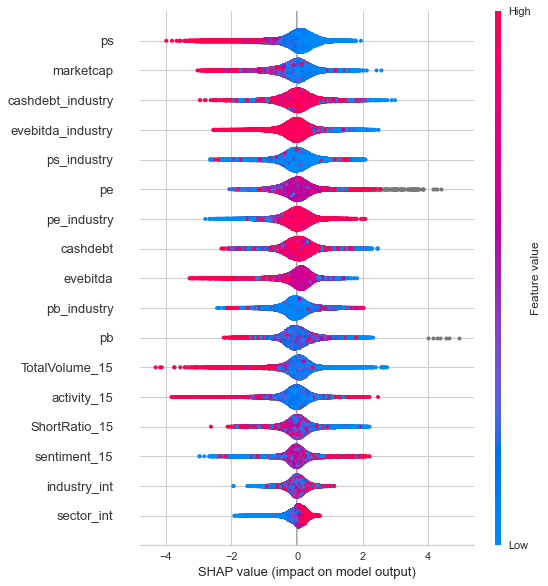

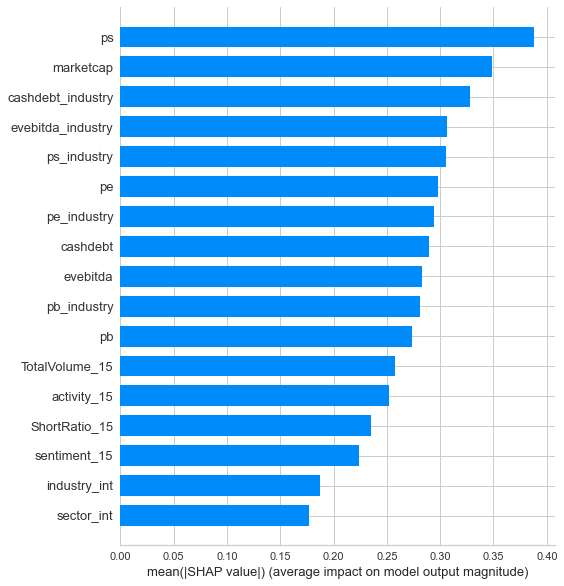

In [87]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Multi-Classification

Idea is to bucket returns into classes